# Определение возраста покупателей

## Описание проекта


Необходимо построить модель определения возраста по фотографии. В дальнейшем модель может быть использована в супермаркетах для определения возраста покупателей с целью контроля продавцов при продаже алкоголя и табачных изделий, а так же для более персонифицированных предложений товаров.

План работы:
- провести исследовательский анализ данных:
  - изучить представленную выборку
  - оценить распределение возрастов в выборке
  - определить строение выборки на примере 10-15 изображений
- настроить и обучить модель
- провести донастройку модели для получения MAE не более 8

## Исследовательский анализ данных

### Введение

In [1]:
import pandas as pd
import random

import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.preprocessing.image import ImageDataGenerator

### Исследование выборки

Для начала, загрузим изображения и возраст, соответствующий этим изображениям.

In [2]:
IMAGE_PATH = '/datasets/faces/'
TARGET_PATH = '/datasets/faces/labels.csv'

In [3]:
target = pd.read_csv(TARGET_PATH)
target.shape

(7591, 2)

In [4]:
datagen = ImageDataGenerator(rescale=1/255.)
datagen_flow = datagen.flow_from_directory(
        IMAGE_PATH,
        target_size=(300, 300),
        batch_size=32,
        class_mode='input',
        seed=12345)

Found 7591 images belonging to 1 classes.


Исходя из полученной информации, в выборке содержится 7591 фотография.
Если предположить, что в выборке находятся изображения людей в возрасте от 0 до 100 лет, то даже при разибении на категории по 10 лет (0-10, 11-20) в лучшем случае в выборке будет не больше 750 фотографий на каждую категорию. Учитывая это, нельзя сказать, что наблюдений достаточно на каждый класс, а следовательно, при обучении модели стоит использовать аугментации для своеобразного увеличения выборки.

Рассмотрим распределение возраста в имеющейся у нас выборке.

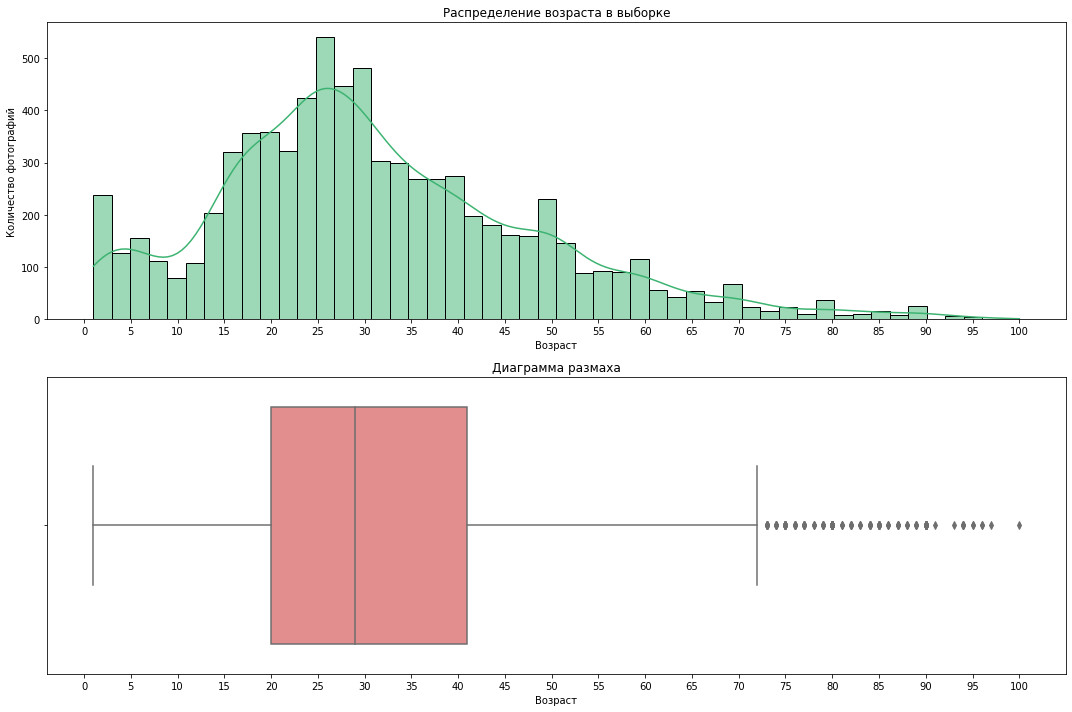

In [21]:
fig, axs = plt.subplots(2,1, figsize=(15, 10))

sns.histplot(target['real_age'], bins=50, color='mediumseagreen', kde=True, ax=axs[0])
axs[0].set_title('Распределение возраста в выборке')
axs[0].set_xlabel('Возраст')
axs[0].set_ylabel('Количество фотографий')
axs[0].set_xticks(range(0, 105, 5))

sns.boxplot(data=target, x='real_age', color='lightcoral', ax=axs[1], orient='h')
axs[1].set_title('Диаграмма размаха')
axs[1].set_xlabel('Возраст')
axs[1].set_xticks(range(0, 105, 5))

plt.tight_layout()
plt.show()

Распределение выше близко к распределению Пуассона.
Из гистограммы выше видно, что чаще всего (около 300 изображений для каждого возраста) в выборке встречаются люди около 27 и 30 лет. Кроме того, присутствует большое количество изображений с детьми в возрасте 1 года, 40 и 50 лет (по 150 изображений). Эти возраста выбиваются из общей картины распределения возрастов в выборке. В целом, можно сказать, что количество фотографий падает на промежутке от 1 до 10 лет, затем растет до 25 лет, где достигает максимальных значений, а затем падает по мере увеличения возраста.
В целом, это совпадает с мировой статистикой (в структуре населения мира доля детей составляет в среднем 26%, взрослых — 65%, пожилых — 9%).

При анализе диаграммы размаха, можно отметить, что выбросы наблюдаются после ~73 лет. Медианное значение находится в районе 30 лет, а первый и третий квартили находятся, соответственно, в районе 20 и 40 лет.

Рассмотрим примеры изображений из выборки.

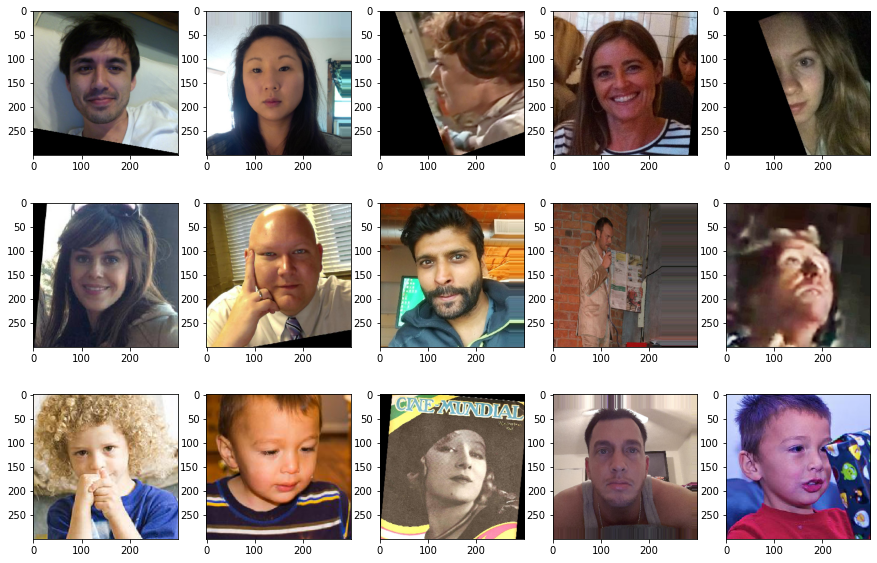

In [26]:
fig, axs = plt.subplots(3, 5, figsize=(15, 10))

random.seed(12345)

random_indices = random.sample(range(len(datagen_flow)), 15)

for i, idx in enumerate(random_indices):
    batch = datagen_flow[idx]
    images = batch[0]
    ages = []
    for j in range(len(images)):
        img = images[j]
        axs[i // 5, i % 5].imshow(img)
        
plt.show()

Как мы видим по представленному случайному набору фотографий из выборки, в ней содержатся абсолютно разные фотографии: часть является домашними фотографиями, либо селфи, присутствуют обработанные фотографии с фотосессий, а так же увеличенные скриншоты с видео, например, пресс-конференций или фильмов. Кроме того, на некоторых фотографиях лицо обрезано, а некоторые требовалось поворачивать для выравнивания. Необходимо отметить, что фотографии не только анфас, но еще и с поворотами лиц, с разной яркостью и разным разрешением. Размер у всех фотографий одинаковый, приводить к общему не нужно.

### Выводы

Исходя из проведенного анализа выборки, можно сделать вывод, что данная выборка имеет малое количество экземпляров с возрастом более 60 лет, что повлияет на ее возможность определять возраст в группе от 60 до 100 лет. Кроме того, резкое падение количества людей на фотографиях в возрасте 10 лет так же уменьшит точность в районе этого возраста.
Стоит дополнительно увеличить выборку с помощью различных аугментаций.
Случайная выборка из 15 фотографий показала, что все изображения расположены правильно, следовательно аугментация в виде горизонтального переворота не потребуется.

## Обучение модели

```python

import pandas as pd
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np

def load_train(path):
    target = pd.read_csv(path + 'labels.csv')
    image_path = path + '/final_files'
    train_datagen = ImageDataGenerator(
        validation_split=0.25,
        rescale = 1 / 255.,
        horizontal_flip = True,
        width_shift_range = 0.4,
        height_shift_range = 0.4
    )

    train_datagen_flow = train_datagen.flow_from_dataframe(
        dataframe=target,
        directory=image_path,
        x_col='file_name',
        y_col='real_age',
        target_size=(150, 150),
        batch_size=16,
        class_mode='raw',
        subset='training',
        seed=12345)
    return train_datagen_flow

def load_test(path):
    image_path = path + 'final_files/'
    target = pd.read_csv(path + 'labels.csv')
    valid_datagen = ImageDataGenerator(validation_split=0.25,
                                       rescale=1 / 255.
                                       )
    valid_datagen_flow = valid_datagen.flow_from_dataframe(
        dataframe=target,
        directory=image_path,
        x_col='file_name',
        y_col='real_age',
        target_size=(150, 150),
        batch_size=16,
        class_mode='raw',
        subset='validation',
        seed=12345)
    return valid_datagen_flow

def create_model(input_shape):
    model = Sequential()
    backbone = ResNet50(
        input_shape=input_shape,
        weights='/datasets/keras_models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5',
        include_top=False
    )
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))
    optimizer = Adam(lr=0.0001)
    model.summary()
    model.compile(optimizer=optimizer, loss='mean_squared_error',
                  metrics=['mae'])

    return model

def train_model(model, train_data, test_data, batch_size=None, epochs=3,
               steps_per_epoch=None, validation_steps=None):

    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2, shuffle=True)

    return model

```

<div class="alert alert-success">
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b> Получилось собрать хорошую модель:
- `train` и `test` не пересекаются за счёт `seed`;
- выбрана `mse` в качестве функции потерь - оценка модели будет стабильнее;
- применена агументация `horizontal_flip` - получим отзеркаленные изображения, и это может помочь модели давать лучшее качество;
- аугментация применена только к `train` - оценка модели будет несмещённой;
- размер `valid` части достаточен для получения надёжной промежуточной оценки;
- в качестве целевой метрики указана `mae` в соответствии с условием проекта.
    
Дополнительно можно пробовать другие техники аугментации для повышения качества модели:
- повороты;
- приближение-отдаление;
- повышение/снижение яркости/контрастности.

```
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
=================================================================
resnet50 (Model)             (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 2049      
=================================================================
Total params: 23,589,761
Trainable params: 23,536,641
Non-trainable params: 53,120
_________________________________________________________________
<class 'tensorflow.python.keras.engine.sequential.Sequential'>

Train for 356 steps, validate for 119 steps
Epoch 1/3
2023-10-04 12:21:29.268164: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2023-10-04 12:21:29.711591: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
356/356 - 82s - loss: 243.9748 - mae: 11.5173 - val_loss: 660.3481 - val_mae: 20.7328
Epoch 2/3
356/356 - 73s - loss: 127.7574 - mae: 8.6195 - val_loss: 169.3460 - val_mae: 9.8056
Epoch 3/3
356/356 - 73s - loss: 110.4907 - mae: 7.9593 - val_loss: 108.9455 - val_mae: 7.9239

119/119 - 11s - loss: 108.9455 - mae: 7.9239
Test MAE: 7.9239
```

## Анализ обученной модели

Для обучение была выбрана модель ResNet50 без 2 верхних слоев.
В качестве верхних слоев были добавлены глобальный пулинг и "густой" слой с активацией ReLU, чтобы исключить отрицательные ответы.
Исходя из анализа выборки, в качестве аугментаций были выбраны горизонтальный переворот, а также сдвиг по ширине и высоте.
Шаг обучения у оптимизатора Adam составил 0.0001, а в качестве функции потерь был выбран MSE.
Модель обучалась на 3 эпохах, и показала достаточно хороший результат на выборке.

В результате обучения модели результат MAE на валидационной выборке составил 7.9, что ниже максимально допустимого значения (8.00).

Как мы видим, среднее среднее значение асболютной ошибки составляет около 8 лет. Исходя из этого, стоит оценивать возраст в пределах каких-либо категорий покупателей, например до 0 - 21, 21 - 35, 35- 50 и т.д. Таким образом, шанс предложить нерелевантные товары покупателю меньше. Для оценки возраста покупателя алкоголя/табачной продукции необходимо дополнительно проверять результаты модели для снижения вероятности ошибки.